# EDA o zanieczyszczeniu powietrza na podstawie danych WHO

## Wstęp
Analiza zanieczyszczenia powietrza została przeprowadzona na podstawie danych o zanieczyszczeniu powietrza, udostęnioanych przez WHO. Dane te pochodzą z wielu stacji z dużej ilości krajów. Dane przedstawiają zanieczyszczenia powietrza pyłami PM2.5, PM10 i NO2. 

## Wczytanie potrzebnych bibliotek

In [133]:
from itables import show
import plotly.express as px
import ipywidgets as widgets
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import ipywidgets as widgets
from IPython.display import display, clear_output
import geopandas as gpd
import contextily as ctx
import matplotlib.pyplot as plt
from ipywidgets import interact, Dropdown


## Wczytanie danych

In [134]:
file_path = 'who_aap_2021_v9_11august2022.xlsx'
air_pollution_data = pd.read_excel(file_path, sheet_name='AAP_2022_city_v9')

## Wyświetlenie danych
Do podglądu danych skorzystano z biblioteki itables, która oferuje funkcje ułatwające przegląd danych. Dzięki funkcji show() możemy wygdoniej przeglądać analziowane dane.

In [124]:
show(air_pollution_data)
print(f"Ilość rekordów: {len(air_pollution_data)}")

Ilość rekordów: 32186


## Przygotowanie danych
Zostały usunięte rekordy, które mają pokrycie czasowe na poziomie niższym niż 50% (lub wartość pokrycia czasowego jest nieznana). Zostało to spowodowane faktem, że wartości dla poszczególnych zanieczyszczeń w przypadku niskiego pokrycia czasowego mogą być niemiarodajne. Pomiary mogły być zrobione tylko w jednym okresie roku, w którym zanieczyszczenie jest znacząco wyższe lub niższe. Wyeliminowanie tych danych ma na celu zapewnienie większej wiarygodności i spójności analizy zanieczyszczenia powietrza. Podczas tego procesu ilość danych została zredukowana do 25365.

In [135]:
# Usuwanie rekordów z pokryciem czasowym mniejszym niż 50% lub NaN dla PM2.5, PM10, NO2
cleaned_data = air_pollution_data.dropna(subset=['PM25 temporal coverage (%)', 'PM10 temporal coverage (%)', 'NO2 temporal coverage (%)'], how='all')
cleaned_data = cleaned_data[
    (cleaned_data['PM25 temporal coverage (%)'] >= 50) |
    (cleaned_data['PM10 temporal coverage (%)'] >= 50) |
    (cleaned_data['NO2 temporal coverage (%)'] >= 50)
]
print(f"Ilość rekordów po obróbce: {len(cleaned_data)}")

Ilość rekordów po obróbce: 25360


Aby przyśpieszyć procesy obliczeniowe z dataframe zostały usuniete kolumny, które nie będą potrzebne w dalszej części projektu.

In [136]:
columns_to_drop = ['ISO3', 'Reference', 'Number and type of monitoring stations', 'Version of the database', 'Status']
cleaned_data.drop(columns=columns_to_drop, inplace=True)

## Analiza danych
Macierz koleracji:

In [137]:
correlation_matrix = cleaned_data[['PM2.5 (μg/m3)', 'PM10 (μg/m3)', 'NO2 (μg/m3)']].corr()
print(correlation_matrix)

               PM2.5 (μg/m3)  PM10 (μg/m3)  NO2 (μg/m3)
PM2.5 (μg/m3)       1.000000      0.880986     0.431702
PM10 (μg/m3)        0.880986      1.000000     0.297277
NO2 (μg/m3)         0.431702      0.297277     1.000000


Na podstawie macierzy koleracji widać wysoką kolerację pomiedzy wartościami PM2.5 oraz PM10. Dzięki temu możemy uzupełnić brakujące wartości PM2.5/PM10 na podstawie wartości PM10/PM2.5. Dodatkowo zostały dodane trzy kolumny (każda dla jednego z zanieczyszczeń) informujace czy dana wartość pochodzi ze źródła czy została wyliczona.

In [142]:
# Dodanie kolumn informacyjnych
cleaned_data['PM2.5 Source'] = 'Original'
cleaned_data['PM10 Source'] = 'Original'
cleaned_data['NO2 Source'] = 'Original'

# Obliczenie korelacji między PM2.5 i PM10
correlation_matrix = cleaned_data[['PM2.5 (μg/m3)', 'PM10 (μg/m3)']].corr()
correlation_pm25_pm10 = correlation_matrix.loc['PM2.5 (μg/m3)', 'PM10 (μg/m3)']

# Uzupełnianie brakujących wartości PM2.5 i PM10
for i, row in cleaned_data.iterrows():
    if pd.isna(row['PM2.5 (μg/m3)']) and not pd.isna(row['PM10 (μg/m3)']):
        cleaned_data.at[i, 'PM2.5 (μg/m3)'] = row['PM10 (μg/m3)'] * correlation_pm25_pm10
        cleaned_data.at[i, 'PM2.5 Source'] = 'Calculated'
    elif pd.isna(row['PM10 (μg/m3)']) and not pd.isna(row['PM2.5 (μg/m3)']):
        cleaned_data.at[i, 'PM10 (μg/m3)'] = row['PM2.5 (μg/m3)'] / correlation_pm25_pm10
        cleaned_data.at[i, 'PM10 Source'] = 'Calculated'

## Wizualizacja danych

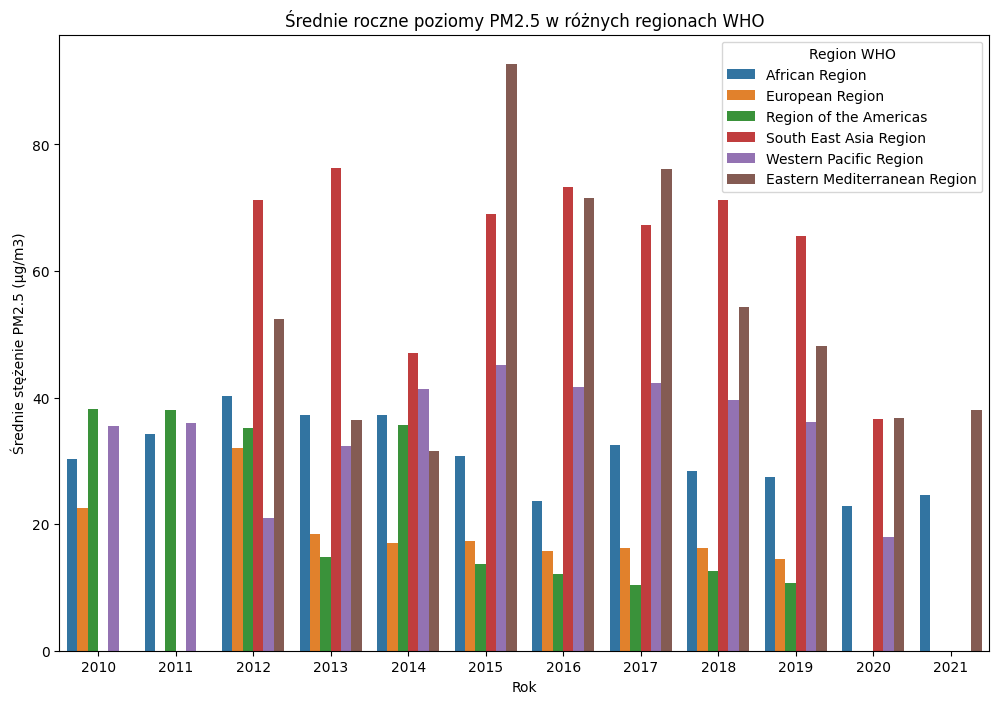

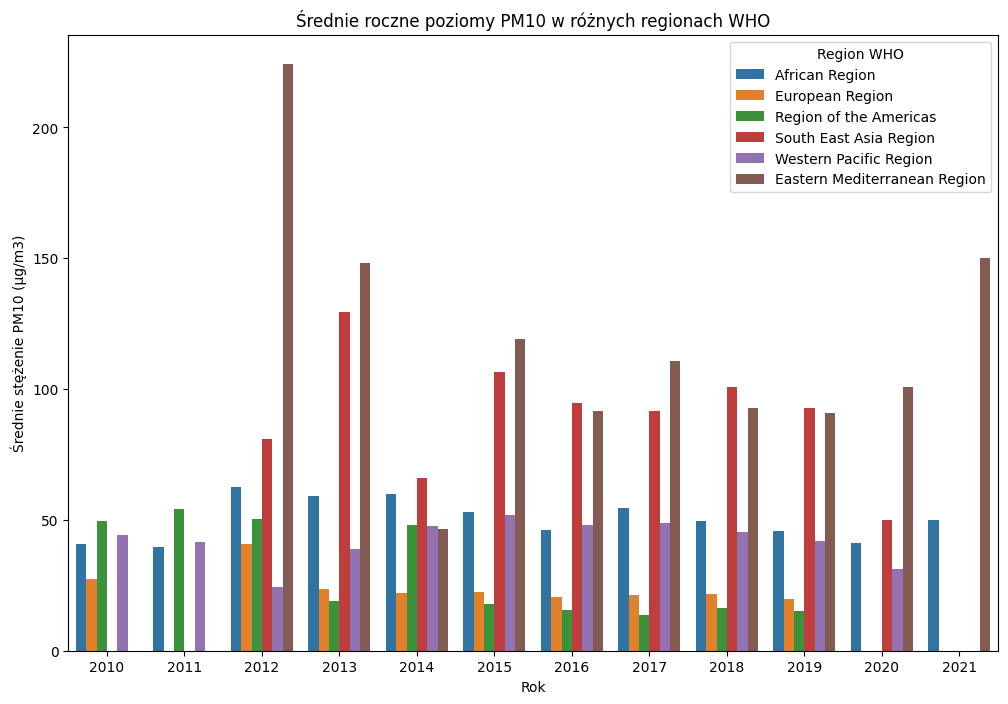

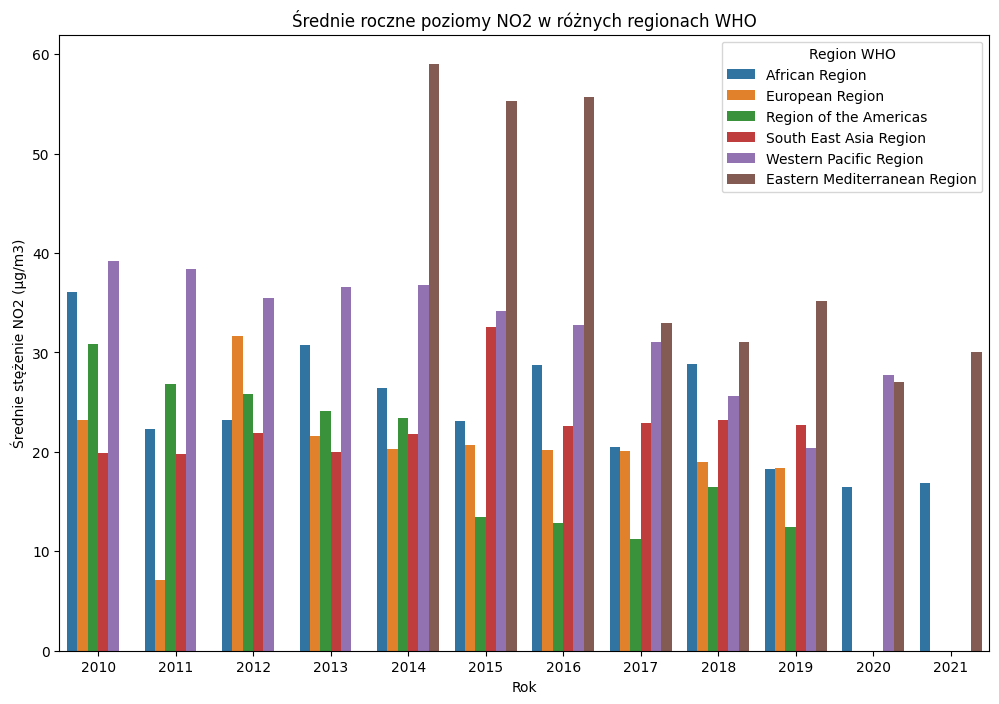

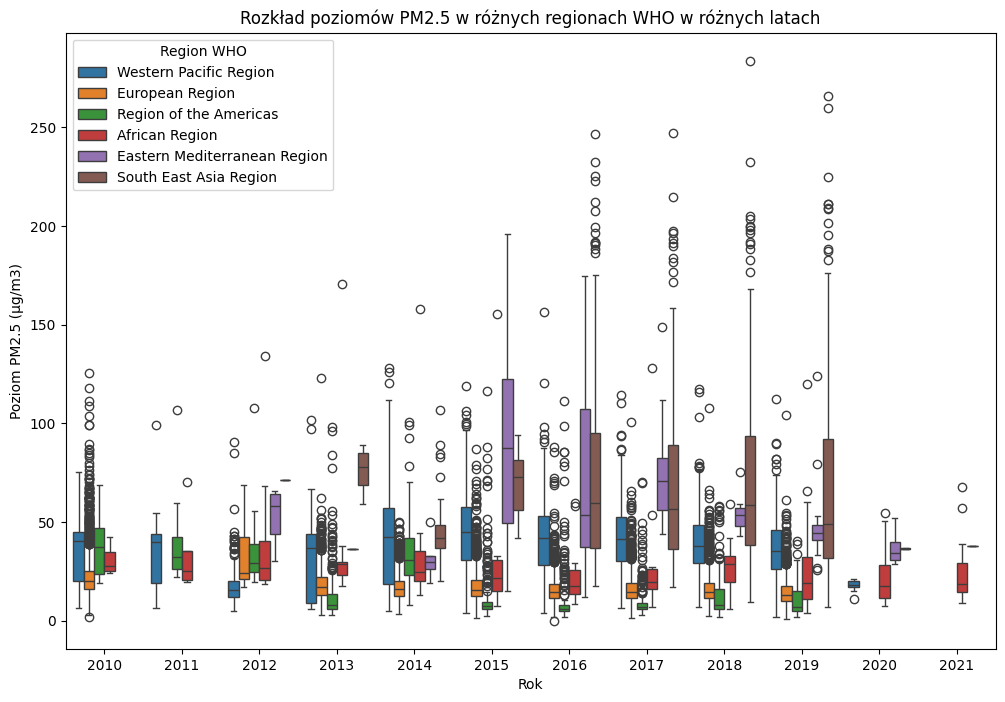

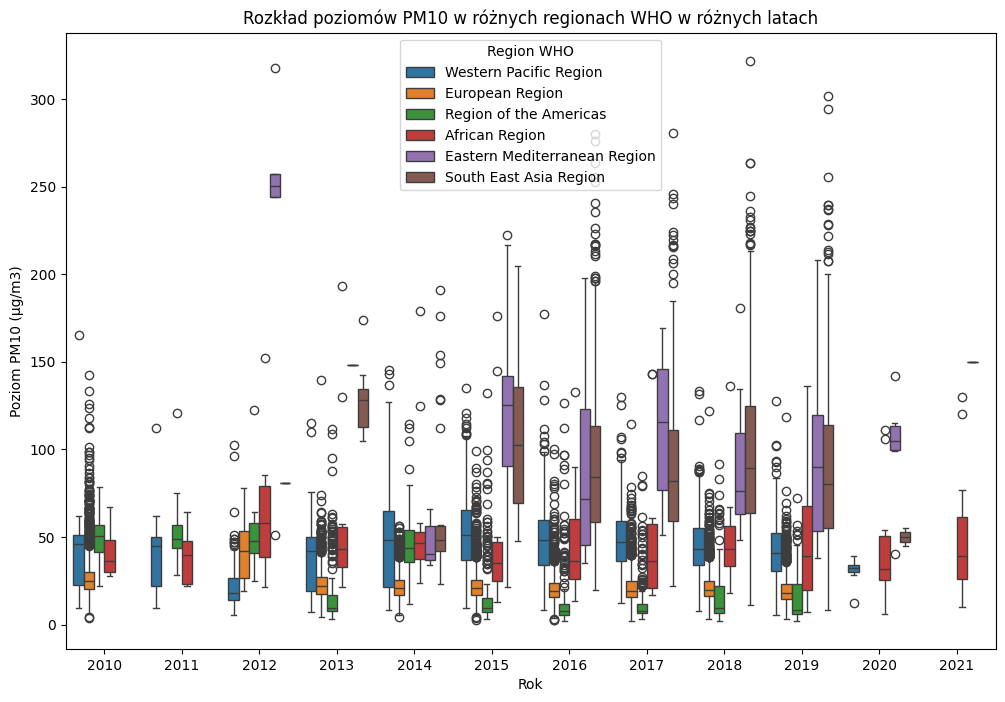

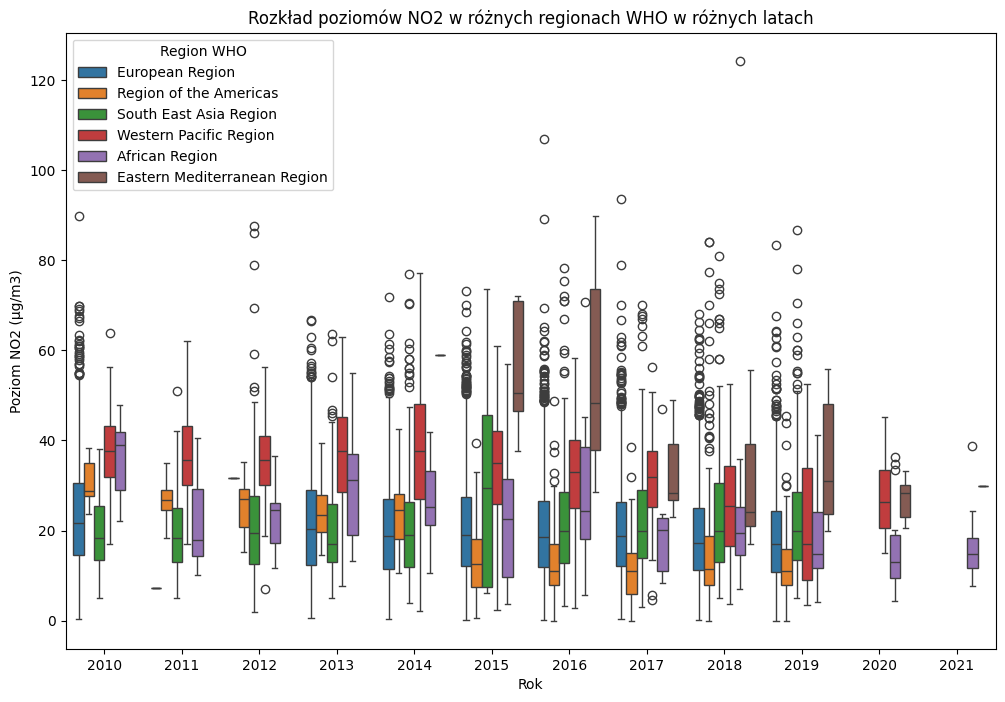

<Figure size 1500x800 with 0 Axes>

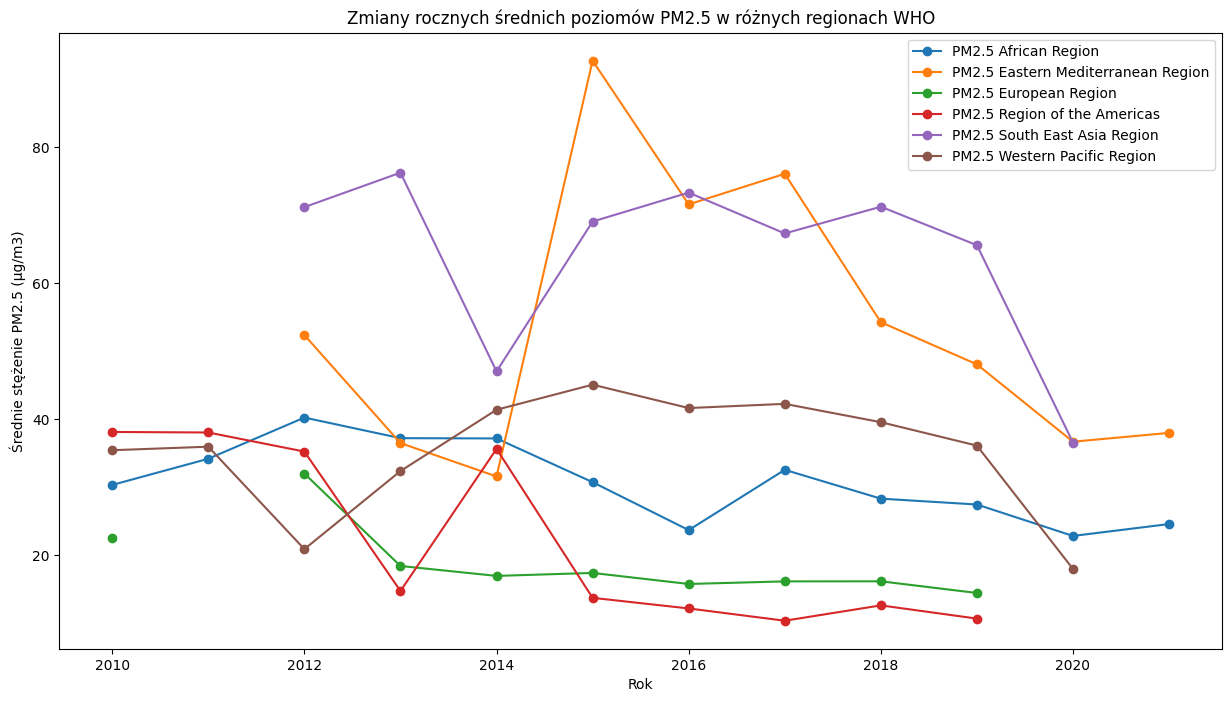

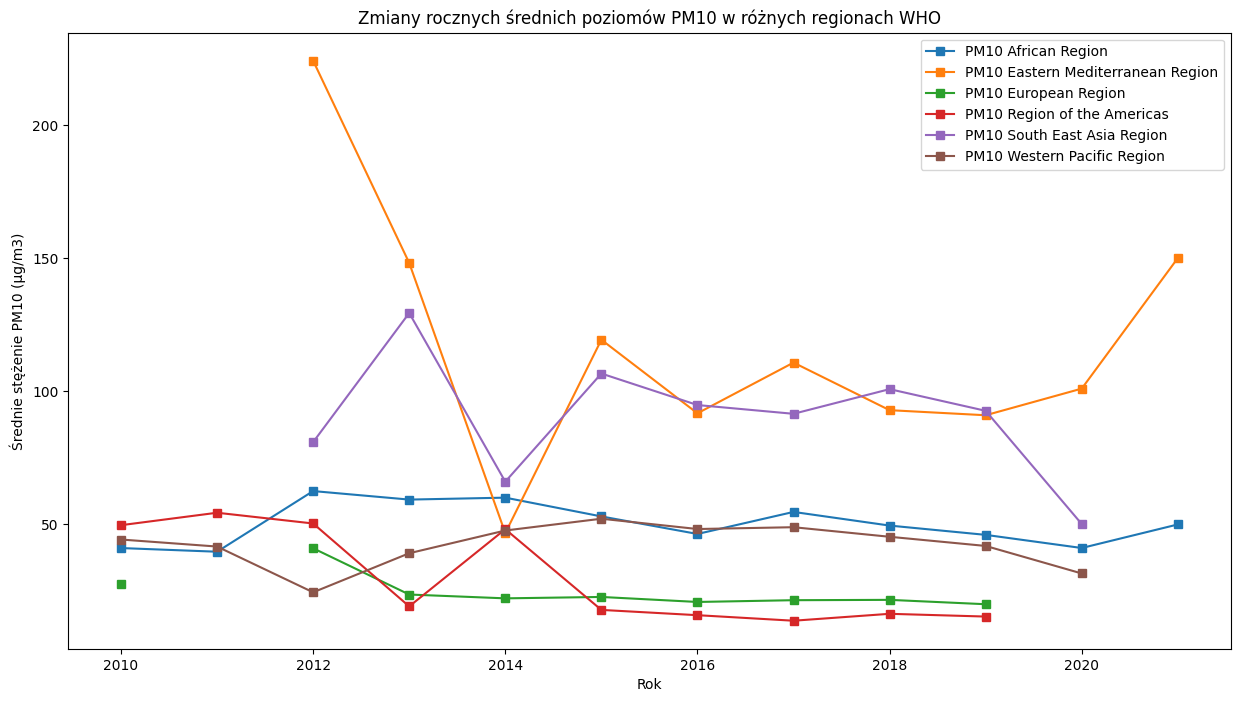

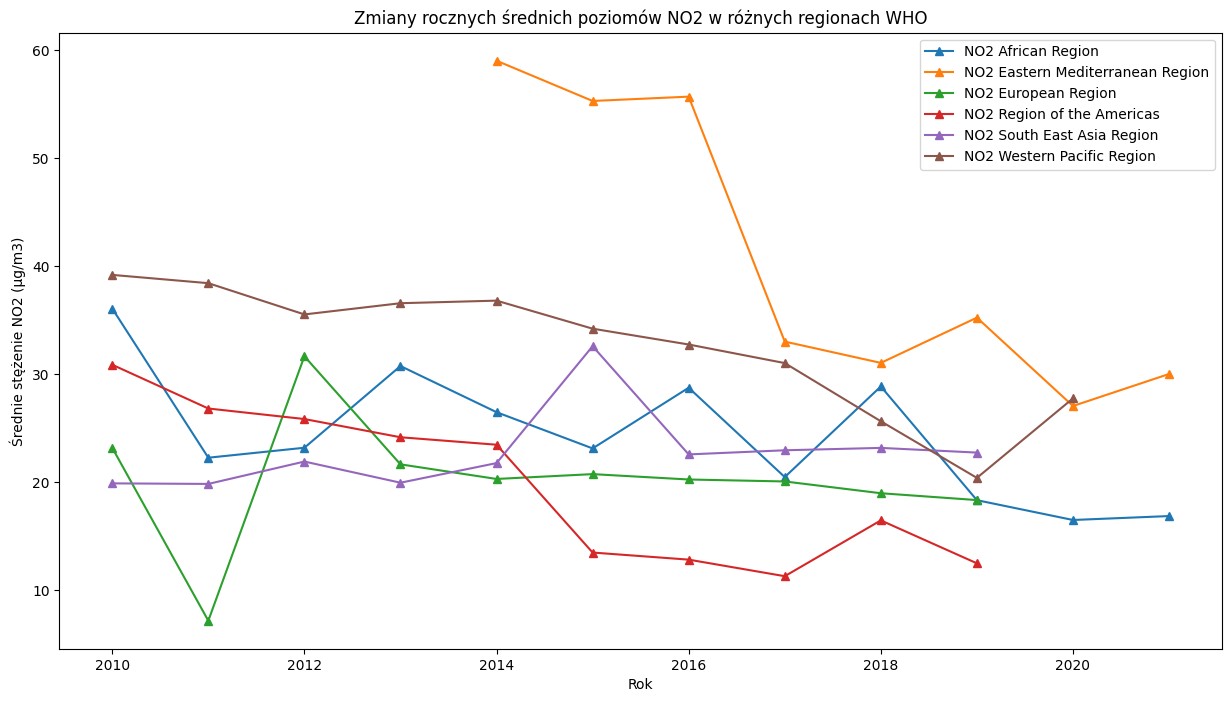

In [103]:
average_pm25_by_region = cleaned_data.groupby(['WHO Region', 'Measurement Year'])['PM2.5 (μg/m3)'].mean().reset_index()

# Wykres słupkowy
plt.figure(figsize=(12, 8))
sns.barplot(x='Measurement Year', y='PM2.5 (μg/m3)', hue='WHO Region', data=average_pm25_by_region)
plt.title('Średnie roczne poziomy PM2.5 w różnych regionach WHO')
plt.ylabel('Średnie stężenie PM2.5 (μg/m3)')
plt.xlabel('Rok')
plt.legend(title='Region WHO')
plt.show()

# Obliczenie średnich wartości PM10 dla każdego regionu WHO i roku
average_pm10_by_region = cleaned_data.groupby(['WHO Region', 'Measurement Year'])['PM10 (μg/m3)'].mean().reset_index()

# Wykres słupkowy
plt.figure(figsize=(12, 8))
sns.barplot(x='Measurement Year', y='PM10 (μg/m3)', hue='WHO Region', data=average_pm10_by_region)
plt.title('Średnie roczne poziomy PM10 w różnych regionach WHO')
plt.ylabel('Średnie stężenie PM10 (μg/m3)')
plt.xlabel('Rok')
plt.legend(title='Region WHO')
plt.show()

# Obliczenie średnich wartości NO2 dla każdego regionu WHO i roku
average_no2_by_region = cleaned_data.groupby(['WHO Region', 'Measurement Year'])['NO2 (μg/m3)'].mean().reset_index()

# Wykres słupkowy
plt.figure(figsize=(12, 8))
sns.barplot(x='Measurement Year', y='NO2 (μg/m3)', hue='WHO Region', data=average_no2_by_region)
plt.title('Średnie roczne poziomy NO2 w różnych regionach WHO')
plt.ylabel('Średnie stężenie NO2 (μg/m3)')
plt.xlabel('Rok')
plt.legend(title='Region WHO')
plt.show()

# Wybierz tylko te wiersze, gdzie PM2.5 jest dostępne
pm25_data = cleaned_data.dropna(subset=['PM2.5 (μg/m3)'])

# Wykres skrzynkowy
plt.figure(figsize=(12, 8))
sns.boxplot(x='Measurement Year', y='PM2.5 (μg/m3)', hue='WHO Region', data=pm25_data)
plt.title('Rozkład poziomów PM2.5 w różnych regionach WHO w różnych latach')
plt.ylabel('Poziom PM2.5 (μg/m3)')
plt.xlabel('Rok')
plt.legend(title='Region WHO')
plt.show()

# Wybierz tylko te wiersze, gdzie PM10 jest dostępne
pm10_data = cleaned_data.dropna(subset=['PM10 (μg/m3)'])

# Wykres skrzynkowy
plt.figure(figsize=(12, 8))
sns.boxplot(x='Measurement Year', y='PM10 (μg/m3)', hue='WHO Region', data=pm10_data)
plt.title('Rozkład poziomów PM10 w różnych regionach WHO w różnych latach')
plt.ylabel('Poziom PM10 (μg/m3)')
plt.xlabel('Rok')
plt.legend(title='Region WHO')
plt.show()

# Wybierz tylko te wiersze, gdzie NO2 jest dostępne
no2_data = cleaned_data.dropna(subset=['NO2 (μg/m3)'])

# Wykres skrzynkowy
plt.figure(figsize=(12, 8))
sns.boxplot(x='Measurement Year', y='NO2 (μg/m3)', hue='WHO Region', data=no2_data)
plt.title('Rozkład poziomów NO2 w różnych regionach WHO w różnych latach')
plt.ylabel('Poziom NO2 (μg/m3)')
plt.xlabel('Rok')
plt.legend(title='Region WHO')
plt.show()

# Obliczanie średnich wartości dla każdego zanieczyszczenia w każdym regionie i roku
mean_pm25 = cleaned_data.groupby(['WHO Region', 'Measurement Year'])['PM2.5 (μg/m3)'].mean().reset_index()
mean_pm10 = cleaned_data.groupby(['WHO Region', 'Measurement Year'])['PM10 (μg/m3)'].mean().reset_index()
mean_no2 = cleaned_data.groupby(['WHO Region', 'Measurement Year'])['NO2 (μg/m3)'].mean().reset_index()

# Tworzenie wykresu liniowego
plt.figure(figsize=(15, 8))

mean_pm25 = cleaned_data.groupby(['WHO Region', 'Measurement Year'])['PM2.5 (μg/m3)'].mean().reset_index()

# Tworzenie wykresu liniowego dla PM2.5
plt.figure(figsize=(15, 8))
for region in mean_pm25['WHO Region'].unique():
    region_data = mean_pm25[mean_pm25['WHO Region'] == region]
    plt.plot(region_data['Measurement Year'], region_data['PM2.5 (μg/m3)'], marker='o', label=f'PM2.5 {region}')

plt.title('Zmiany rocznych średnich poziomów PM2.5 w różnych regionach WHO')
plt.ylabel('Średnie stężenie PM2.5 (μg/m3)')
plt.xlabel('Rok')
plt.legend()
plt.show()

mean_pm10 = cleaned_data.groupby(['WHO Region', 'Measurement Year'])['PM10 (μg/m3)'].mean().reset_index()

# Tworzenie wykresu liniowego dla PM10
plt.figure(figsize=(15, 8))
for region in mean_pm10['WHO Region'].unique():
    region_data = mean_pm10[mean_pm10['WHO Region'] == region]
    plt.plot(region_data['Measurement Year'], region_data['PM10 (μg/m3)'], marker='s', label=f'PM10 {region}')

plt.title('Zmiany rocznych średnich poziomów PM10 w różnych regionach WHO')
plt.ylabel('Średnie stężenie PM10 (μg/m3)')
plt.xlabel('Rok')
plt.legend()
plt.show()

mean_no2 = cleaned_data.groupby(['WHO Region', 'Measurement Year'])['NO2 (μg/m3)'].mean().reset_index()

# Tworzenie wykresu liniowego dla NO2
plt.figure(figsize=(15, 8))
for region in mean_no2['WHO Region'].unique():
    region_data = mean_no2[mean_no2['WHO Region'] == region]
    plt.plot(region_data['Measurement Year'], region_data['NO2 (μg/m3)'], marker='^', label=f'NO2 {region}')

plt.title('Zmiany rocznych średnich poziomów NO2 w różnych regionach WHO')
plt.ylabel('Średnie stężenie NO2 (μg/m3)')
plt.xlabel('Rok')
plt.legend()
plt.show()

Na podstawie wykresów można zauważyć, że największe zanieczyszczenia powietrza pyłami PM2.5 oraz PM10 występują w regionach wschodniej części Morza Śródziemnego oraz Południowo-wschodniej Azji. W przypadku wchodzniej częsci morza Śródziemnego dysponujemy danymi od 2014 roku, więc nie jest wiadome jak sytuacja wyglądała wcześniej. PM2.5 oraz PM10 w więszkości analizowanych lat było najniższe w regionie Ameryki oraz Europy. Widać, że w przypadku lat 2010, 2011, 2020, 2021 w niektórych regionach brakuje jakichkolwiek danych.
W przypadku zanieczyszczenia NO2, największe zanieczyszczenia odnotowano dla regionu wschodniej części Morza Śródziemnego. Drugie najwyższe zanieczyszczenia pochodzą z regionu zachodniego Pacyfiku. We wszystkich regionach widać tendencje spadkową w kwestii zanieczyszczenia powietrza.

In [121]:
def plot_region_data_for_year(region, year):
    # Filtruj dane dla wybranego regionu i roku
    region_year_data = cleaned_data[(cleaned_data['WHO Region'] == region) & (cleaned_data['Measurement Year'] == year)]

    # Obliczanie średnich wartości dla każdego kraju w regionie
    avg_pm25_by_country = region_year_data.groupby(['WHO Country Name'])['PM2.5 (μg/m3)'].mean().reset_index()
    avg_pm10_by_country = region_year_data.groupby(['WHO Country Name'])['PM10 (μg/m3)'].mean().reset_index()
    avg_no2_by_country = region_year_data.groupby(['WHO Country Name'])['NO2 (μg/m3)'].mean().reset_index()

    # Tworzenie wykresu
    fig, axes = plt.subplots(3, 1, figsize=(12, 18))

    # Wykres PM2.5
    sns.barplot(x='WHO Country Name', y='PM2.5 (μg/m3)', data=avg_pm25_by_country, ax=axes[0])
    axes[0].set_title(f'Średnie poziomy PM2.5 w {region} w roku {year}')
    axes[0].set_ylabel('Średnie stężenie PM2.5 (μg/m3)')
    axes[0].set_xlabel('Kraj')
    axes[0].tick_params(axis='x', rotation=90) # Obracanie etykiet

    # Wykres PM10
    sns.barplot(x='WHO Country Name', y='PM10 (μg/m3)', data=avg_pm10_by_country, ax=axes[1])
    axes[1].set_title(f'Średnie poziomy PM10 w {region} w roku {year}')
    axes[1].set_ylabel('Średnie stężenie PM10 (μg/m3)')
    axes[1].set_xlabel('Kraj')
    axes[1].tick_params(axis='x', rotation=90) # Obracanie etykiet

    # Wykres NO2
    sns.barplot(x='WHO Country Name', y='NO2 (μg/m3)', data=avg_no2_by_country, ax=axes[2])
    axes[2].set_title(f'Średnie poziomy NO2 w {region} w roku {year}')
    axes[2].set_ylabel('Średnie stężenie NO2 (μg/m3)')
    axes[2].set_xlabel('Kraj')
    axes[2].tick_params(axis='x', rotation=90) # Obracanie etykiet

    plt.tight_layout()
    plt.show()

# Interaktywny widget do wyboru regionu i roku
regions = cleaned_data['WHO Region'].unique()
years = sorted(cleaned_data['Measurement Year'].unique())
region_dropdown = Dropdown(options=regions, description='Wybierz region:')
year_dropdown = Dropdown(options=years, description='Wybierz rok:')

interact(plot_region_data_for_year, region=region_dropdown, year=year_dropdown)

interactive(children=(Dropdown(description='Wybierz region:', options=('European Region', 'Eastern Mediterrane…

<function __main__.plot_region_data_for_year(region, year)>

Dzięki wykresowi słupkowemu, który przedstawiwa jakoś powietrza w danym kraju we wskazanym regionie oraz roku, można dostrzec w jakich krajach występuje największe zanieczyszczenie powietrza. Dodatkowo dobrze obrazuje on z jakich kraji pochodzą analizowane dane. Widać, że region europy jest regionem w którym najwięcej kraji analizuje jakość powietrza.

In [122]:
# Funkcja aktualizująca listę stacji badawczych po wybraniu kraju
def update_station_dropdown(*args):
    selected_country = country_dropdown.value
    stations = cleaned_data[cleaned_data['WHO Country Name'] == selected_country]['City or Locality'].unique()
    station_dropdown.options = stations

# Funkcja generująca wykres dla wybranej stacji i kraju
def plot_data_for_station_country(country, station):
    if not station:
        return
    # Filtruj dane dla wybranej stacji i kraju
    station_data = cleaned_data[(cleaned_data['WHO Country Name'] == country) & (cleaned_data['City or Locality'] == station)]

    # Sprawdź, czy są dostępne dane
    if station_data.empty:
        print(f"Brak danych dla stacji {station} w kraju {country}.")
        return

    # Tworzenie wykresów
    fig, axes = plt.subplots(3, 1, figsize=(10, 15))

    # Lista zanieczyszczeń do wyświetlenia
    pollutants = ['PM2.5 (μg/m3)', 'PM10 (μg/m3)', 'NO2 (μg/m3)']

    for ax, pollutant in zip(axes, pollutants):
        if pollutant in station_data.columns:
            sns.barplot(x='Measurement Year', y=pollutant, data=station_data, ax=ax)
            ax.set_title(f'{pollutant} w stacji {station} w kraju {country}')
            ax.set_ylabel(pollutant)
            ax.set_xlabel('Rok')
            ax.tick_params(axis='x', rotation=90)
        else:
            ax.text(0.5, 0.5, f'Brak danych {pollutant}', ha='center', va='center', fontsize=12)
            ax.axis('off')

    plt.tight_layout()
    plt.show()

# Interaktywny widget do wyboru kraju
countries = cleaned_data['WHO Country Name'].unique()
country_dropdown = Dropdown(options=countries, description='Wybierz kraj:')
country_dropdown.observe(update_station_dropdown, 'value')

# Pusty dropdown dla stacji badawczych, który zostanie zaktualizowany po wybraniu kraju
station_dropdown = Dropdown(description='Wybierz stację:')

# Pokazanie interaktywnego widgetu
interact(plot_data_for_station_country, country=country_dropdown, station=station_dropdown)

interactive(children=(Dropdown(description='Wybierz kraj:', options=('Albania', 'Andorra', 'United Arab Emirat…

<function __main__.plot_data_for_station_country(country, station)>

Powyższy wykres pozwala na przeanlizowanie zanieczyszczenia powietrza w przypadku, gdy jest potrzeba sprawdzenia konkretnej stacji badawczej. Widać dzięki niemu, jak na przestrzeni lat, zmieniało się zanieczyszczenie w konkretym punkcie.

## Wizualizacja geoprzestrzenna danych
Z uwagii na brak kordynatów punktów badawczych w zestawie danych, zostały one dopasowane na podstawie zestawu danych udostępnianego przez <strong>OpenDataSoft</strong>. Udało się dopasować kordynaty 4924 lokalizacji z 5927. Podczas przygotowywania danych została również podnięta próba pozyskania danych z API wykorzystującego OpenStreetMap, ale z uwagii na wolny czas uzupełniania danych, ta metoda została odrzucona.

In [ ]:
geo_data = pd.read_csv('geonames-all-cities-with-a-population-1000.csv', delimiter=';')

# Konwersja kolumny 'Alternate Names' na listę
geo_data['Alternate Names'] = geo_data['Alternate Names'].apply(lambda x: x.split(',') if pd.notnull(x) else [])

# Funkcja do znajdowania współrzędnych
def find_coordinates(row, geo_df):
    city = row['City or Locality']
    # Próba dopasowania przez NAME
    coords = geo_df[geo_df['Name'] == city]['Coordinates']
    if coords.empty:
        # Próba dopasowania przez ASCII Name
        coords = geo_df[geo_df['ASCII Name'] == city]['Coordinates']
        if coords.empty:
            # Próba dopasowania przez Alternate Names
            coords = geo_df[geo_df['Alternate Names'].apply(lambda x: city in x)]['Coordinates']
            if coords.empty:
                return None, None
    coords = coords.iloc[0]
    lat, long = coords.split(', ')
    return lat, long

# Dodanie kolumn współrzędnych do cleaned_data
cleaned_data[['Latitude', 'Longitude']] = cleaned_data.apply(lambda row: find_coordinates(row, geo_data), axis=1, result_type='expand')

# Eksport danych (z uwagi na długi czas wykonywania sie funkcji
cleaned_data.to_csv('cleaned_data_with_coordinates.csv', index=False)

In [87]:
cleaned_data = pd.read_csv('cleaned_data_with_coordinates.csv', delimiter=',')
show(cleaned_data)

In [88]:
# Liczba unikalnych miast w danych
total_cities = cleaned_data['City or Locality'].nunique()
# Liczba miast bez dopasowanych współrzędnych
cities_without_coordinates = cleaned_data[cleaned_data['Latitude'].isna() | cleaned_data['Longitude'].isna()]['City or Locality'].nunique()

print("Całkowita liczba unikalnych miast:", total_cities)
print("Liczba miast bez dopasowanych współrzędnych:", cities_without_coordinates)

Całkowita liczba unikalnych miast: 5922
Liczba miast bez dopasowanych współrzędnych: 2001


### Utworzenie map przedstawiających punkty badawcze

In [108]:
def create_maps_for_each_year_with_valid_data(data, year):
    # Filtrujemy dane
    filtered_data = data[data['Measurement Year'] == year]
    color_scale = [(0, "green"), (0.25, "yellow"), (0.6, "orange"), (1, "red")]

    # Tworzymy mapy dla poszczególnych zanieczyszczeń
    figPM25 = px.scatter_mapbox(filtered_data, lat='Latitude', lon='Longitude', color='PM2.5 (μg/m3)',
                                color_continuous_scale=color_scale,
                                hover_name='City or Locality', hover_data=['PM2.5 (μg/m3)', 'PM10 (μg/m3)', 'NO2 (μg/m3)'],
                                title=f'Globalne zanieczyszczenie powietrza PM2.5 w roku {year}',
                                mapbox_style='carto-positron', zoom=1, height=500)
    
    figPM10 = px.scatter_mapbox(filtered_data, lat='Latitude', lon='Longitude', color='PM10 (μg/m3)',
                                color_continuous_scale=color_scale,
                                hover_name='City or Locality', hover_data=['PM2.5 (μg/m3)', 'PM10 (μg/m3)', 'NO2 (μg/m3)'],
                                title=f'Globalne zanieczyszczenie powietrza PM10 w roku {year}',
                                mapbox_style='carto-positron', zoom=1, height=500)
    
    figNO2 = px.scatter_mapbox(filtered_data, lat='Latitude', lon='Longitude', color='NO2 (μg/m3)',
                               color_continuous_scale=color_scale,
                               hover_name='City or Locality', hover_data=['PM2.5 (μg/m3)', 'PM10 (μg/m3)', 'NO2 (μg/m3)'],
                               title=f'Globalne zanieczyszczenie powietrza NO2 w roku {year}',
                               mapbox_style='carto-positron', zoom=1, height=500)

    # Wyświetlenie map
    figPM25.show()
    figPM10.show()
    figNO2.show()

# Funkcja interaktywna sterująca rokiem
def interactive_maps(year):
    create_maps_for_each_year_with_valid_data(cleaned_data, year)

# Tworzymy suwak do wyboru roku
year_slider = widgets.IntSlider(min=2010, max=2019, step=1, value=2010, description='Rok:')
widgets.interactive(interactive_maps, year=year_slider)



interactive(children=(IntSlider(value=2010, description='Rok:', max=2019, min=2010), Output()), _dom_classes=(…

Mapa przedstawiajaca punkty badawcze pozwala na dostrzeżenie w jakich regionach jest najwięcej puntków pomarów zanieczyszczeń powietrza. Zacząca przewagę w tej kwestii ma obszar Europy. Dzięki tej mapie można również dostrzec punkty, które wyraźnie odstają od innych puntków w sąsiedztwie.

### Utworzenie map przedstawiących średnie zanieczyszczenie powietrza w danym kraju
Do utworzenia mapy posłużono się plikem .geojon który zawierał kontury krajów. Dzięki temu instnieje możliowść ustawienia sybolizacji zależnej od zanieczyszczenia powietrza.

In [92]:
region_bounds = {
    'Cały świat': (-180, -90, 180, 90),
    'European Region': (-25, 35, 70, 70), # Przykładowe granice, dostosuj wg potrzeb
    'Eastern Mediterranean Region': (20, 5, 75, 40), # Przykładowe granice
    'Region of the Americas': (-135, -60, -20, 60), # Przykładowe granice
    'Western Pacific Region': (100, -60, 180, 60), # Przykładowe granice
    'South East Asia Region': (65, -15, 105, 30), # Przykładowe granice
    'African Region': (-25, -40, 50, 40) # Przykładowe granice
}

def create_pollution_maps_for_year(data, year, region, geojson_path):
    # Wczytanie danych geoJSON
    gdf = gpd.read_file(geojson_path)

    # Filtracja danych dla konkretnego roku i regionu
    if region == 'Cały świat':
        year_data = data[data['Measurement Year'] == year]
    else:
        year_data = data[(data['Measurement Year'] == year) & (data['WHO Region'] == region)]

    if year_data.empty:
        print(f"Brak danych dla roku {year} w regionie {region}.")
        return

    # Ustawienie figury i osi dla wykresu
    fig, axes = plt.subplots(3, 1, figsize=(15, 30))

    for i, pollution_type in enumerate(['PM2.5 (μg/m3)', 'PM10 (μg/m3)', 'NO2 (μg/m3)']):
        ax = axes[i]

        columns_to_use = ['WHO Country Name', 'Latitude', 'Longitude', pollution_type]
        filtered_data = year_data[columns_to_use]
        average_pollution = filtered_data.groupby('WHO Country Name').mean().reset_index()
        merged_gdf = gdf.merge(average_pollution, left_on='ADMIN', right_on='WHO Country Name')

        if merged_gdf.empty:
            ax.text(0.5, 0.5, 'Brak danych do wyświetlenia', horizontalalignment='center', verticalalignment='center')
            ax.set_axis_off()
            continue

        # Ustawienie granic mapy na podstawie wybranego regionu
        ax.set_xlim(region_bounds[region][0], region_bounds[region][2])
        ax.set_ylim(region_bounds[region][1], region_bounds[region][3])

        merged_gdf.plot(ax=ax, column=pollution_type, cmap='YlOrRd', legend=True,
                        legend_kwds={'label': f'{pollution_type}, Rok: {year}',
                                     'orientation': "horizontal"})
        
        ctx.add_basemap(ax, crs=gdf.crs.to_string(), source=ctx.providers.OpenStreetMap.Mapnik)
        ax.set_axis_off()

    plt.tight_layout()
    plt.show()

def interactive_pollution_maps(year, region):
    clear_output(wait=True)
    create_pollution_maps_for_year(cleaned_data, year, region, 'countries.geojson')

# Lista regionów WHO
regions = ['Cały świat', 'European Region', 'Eastern Mediterranean Region', 
           'Region of the Americas', 'Western Pacific Region', 'South East Asia Region', 'African Region']

year_slider = widgets.IntSlider(min=2010, max=2019, step=1, value=2010, description='Rok:')
region_dropdown = widgets.Dropdown(options=regions, value='Cały świat', description='Region:')

widgets.interactive(interactive_pollution_maps, year=year_slider, region=region_dropdown)

interactive(children=(IntSlider(value=2010, description='Rok:', max=2019, min=2010), Dropdown(description='Reg…

Powyższe mapy maja zastosowaną sybmolizacje, która jest obliczana na podstawie średniej zanieczyszczenia branej ze wszystkich stacji badawczych w danym kraju. Na jej postawie można zauważyć które kraje wyróżniają się na tle sąsiadów. Dodatkowo dobrze obrazują one, z jakich krajów pochodzą pomiary powietrza.

## Wnioski
### Zanieczysczenia powietrza
Na podstawie analizy można zauważyć, że kraje które należą do regionu Bliskiego Wshodu oraz Południowo-Wschodniej Azji mają najwyższe zanieczyczeania powietrza. Kraje Europy oraz Ameryk wskazują najniższe wartości. Może to wynikać, ze świadomości społeczeństwa na temat środkowiska, podejścia władz do polityki ekologicznej czy też ilości czujników, które mierzyły jakość powietrza. Kraje rozwinięte (np. Europejskie) mają niższe wartości zanieczyszczeń niż kraje azjatyckie, co może wiązać się z większym skupieniem na ekologii.  W przypadku małej ilości czujników dane mogą, źle reprezetować sytuacje jaka panuje w całym kraju.
Widoczny jest trend zmniejszania się ilości zanieczyczeń.
Analizowanie danych na poziomie regionów może być mylące, ponieważ kraje wewnątrz regionu mogą znacznie różnić się pod względem zanieczyszczenia.
### Potencjał uczenia maszynowego, a zanieczyszczenia powietrza
Tworzenie modeli predykcji zanieczyszczenia przy użyciu uczenia maszynowego może być przydatne do szacowania jakości powietrza oraz podejmowania działań mających na celu zapobieganie zanieczyszcczeniu powietrza. Należy jednak pamietać, że modele predykcyjne do prawidłowej pracy potrzebują dużej ilości danych. Uważam, źe na podstawie analizowanych danych nie dałoby się zbudować dokładnego modelu dla całego świata, ponieważ tylko nie które kraje mają kompletne dane. Dodatkowo wartościowe mogłoby się okazać dołączenie danych atmosferycznych, które są ściśle powiązane z zanieczyszczeniami powietrza.